In [163]:
pip install tensorflow keras matplotlib numpy opencv-python


The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [164]:
import os
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [385]:
import os
import csv

def create_labels(image_folder, label):
    # Check if the file is empty to write header
    file_exists = os.path.isfile('labels.csv')
    
    with open('labels.csv', 'a', newline='') as file:
        writer = csv.writer(file)
        
        # Write the header if the file is empty
        if not file_exists or os.path.getsize('labels.csv') == 0:
            writer.writerow(['image', 'label'])
        
        for filename in os.listdir(image_folder):
            if filename.lower().endswith(('.jpg', '.png', '.jpeg')):
                writer.writerow([filename, label])

solar_farm_folder = '/Users/macbookpro/Desktop/SolarProject/SolarFarm_Images'
non_solar_farm_folder = '/Users/macbookpro/Desktop/SolarProject/Non_SolarFarms'

# Create labels
create_labels(solar_farm_folder, 1)  # Label 1 for solar farms
create_labels(non_solar_farm_folder, 0)  # Label 0 for non-solar farms


In [386]:
base_dir = '/Users/macbookpro/Desktop/SolarProject/dataset'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Create directories if they don't exist
os.makedirs(os.path.join(train_dir, 'solar_farm'), exist_ok=True)
os.makedirs(os.path.join(train_dir, 'non_solar_farm'), exist_ok=True)
os.makedirs(os.path.join(validation_dir, 'solar_farm'), exist_ok=True)
os.makedirs(os.path.join(validation_dir, 'non_solar_farm'), exist_ok=True)


In [387]:
df = pd.read_csv('labels.csv')
solar_farm_folder = '/Users/macbookpro/Desktop/SolarProject/SolarFarm_Images'
non_solar_farm_folder = '/Users/macbookpro/Desktop/SolarProject/Non_SolarFarms'

def split_and_copy_images(df, img_folder, output_train_folder, output_validation_folder, test_size=0.2):
    # Split dataframe
    train_df, val_df = train_test_split(df, test_size=test_size, stratify=df['label'])
    
    # Copy images to respective directories
    for index, row in train_df.iterrows():
        src_path = os.path.join(img_folder, row['image'])
        dest_path = output_train_folder
        shutil.copy(src_path, dest_path)
    
    for index, row in val_df.iterrows():
        src_path = os.path.join(img_folder, row['image'])
        dest_path = output_validation_folder
        shutil.copy(src_path, dest_path)

# Split and copy images
split_and_copy_images(df[df['label'] == 1], solar_farm_folder, os.path.join(train_dir, 'solar_farm'), os.path.join(validation_dir, 'solar_farm'))
split_and_copy_images(df[df['label'] == 0], non_solar_farm_folder, os.path.join(train_dir, 'non_solar_farm'), os.path.join(validation_dir, 'non_solar_farm'))

In [447]:
image_size = (150, 150)
batch_size =32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    # rotation_range=10,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.2,
    zoom_range=[1.5, 2.5],
    # horizontal_flip=True,
    #fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255,
                                       zoom_range=[1.5,2.5])

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=32,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=image_size,
    batch_size=15,
    class_mode='binary'
)

Found 221 images belonging to 2 classes.
Found 56 images belonging to 2 classes.


In [418]:
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.layers import Dropout
from keras.layers import GlobalMaxPooling2D, BatchNormalization
def create_cnn_model():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    #model.add(layers.MaxPooling2D((2, 2)))
    # model.add(layers.Flatten())
    model.add(GlobalMaxPooling2D())
    layers.Dense(512, activation='relu'),
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

model = create_cnn_model()

In [434]:
def build_model():
    model = Sequential()
    # layer-1
    #filter is convolutional matrix which is applied across the image = 32 filters
    #kernal size is 3x3 matrix(filter)
    #relu positive kept as it is, negative is taken out
    model.add(Conv2D(filters=32,
                     kernel_size=3,
                     activation='relu',
                     input_shape=(150, 150, 3)))

    #adding normalizing layer to improve the speed of training
    model.add(BatchNormalization())

    # layer-2
    model.add(Conv2D(filters=64,
                     kernel_size=3,
                     activation='relu'))
    model.add(BatchNormalization())

    # layer-3
    model.add(Conv2D(filters=128,
                     kernel_size=3,
                     activation='relu'))
    model.add(BatchNormalization())

    # Pooling layer is to reduce dimentions of feature map by summerizing presence of features
    # max-pool - sends only imp data to next layer - here 2x2 matrix
    model.add(MaxPooling2D(pool_size=2))

    # layer-4
    model.add(Conv2D(filters=64,
                     kernel_size=3,
                     activation='relu'))
    model.add(BatchNormalization())

    # layer-5
    model.add(Conv2D(filters=128,
                     kernel_size=3,
                     activation='relu'))
    model.add(BatchNormalization())

    # max-pool
    model.add(MaxPooling2D(pool_size=2))

    # layer-6
    model.add(Conv2D(filters=64,
                     kernel_size=3,
                     activation='relu'))
    model.add(BatchNormalization())

    # layer-7
    model.add(Conv2D(filters=128,
                     kernel_size=3,
                     activation='relu'))
    model.add(BatchNormalization())

    # gobal-max-pool- performs downsampling by computing the maximum of the height and width dimensions of the input
    # using it as a substitute of Flatten before passing it to the final layer
    model.add(GlobalMaxPooling2D())

    # output layer
    model.add(Dense(1, activation='sigmoid'))

    # compile model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model
model = create_cnn_model()

In [448]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples //15
)

Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 574ms/step - accuracy: 0.9190 - loss: 0.2444 - val_accuracy: 0.8444 - val_loss: 0.4110
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8966 - loss: 0.2600 - val_accuracy: 0.8182 - val_loss: 0.4657
Epoch 3/10


2024-07-25 10:39:03.833909: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)
2024-07-25 10:39:03.896052: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 528ms/step - accuracy: 0.9317 - loss: 0.1832 - val_accuracy: 0.8000 - val_loss: 0.3878
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8438 - loss: 0.4291 - val_accuracy: 0.9091 - val_loss: 0.2300
Epoch 5/10


2024-07-25 10:39:09.775879: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-25 10:39:09.842232: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 506ms/step - accuracy: 0.8664 - loss: 0.2761 - val_accuracy: 0.8444 - val_loss: 0.3558
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9310 - loss: 0.1492 - val_accuracy: 0.9091 - val_loss: 0.3272
Epoch 7/10


2024-07-25 10:39:15.620475: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-25 10:39:15.684559: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 511ms/step - accuracy: 0.8804 - loss: 0.2425 - val_accuracy: 0.8444 - val_loss: 0.3024
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9688 - loss: 0.0981 - val_accuracy: 0.8182 - val_loss: 0.4617
Epoch 9/10


2024-07-25 10:39:21.464397: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-25 10:39:21.526560: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 525ms/step - accuracy: 0.8883 - loss: 0.2341 - val_accuracy: 0.8444 - val_loss: 0.3314
Epoch 10/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8750 - loss: 0.3062 - val_accuracy: 0.6364 - val_loss: 0.3901


2024-07-25 10:39:27.483856: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-25 10:39:27.552144: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


In [449]:
test_loss, test_acc = model.evaluate(validation_generator)
print(f'Test accuracy: {test_acc}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.8197 - loss: 0.3279
Test accuracy: 0.8214285969734192


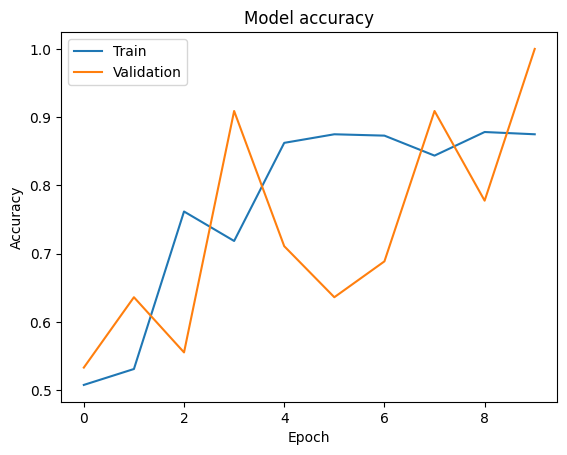

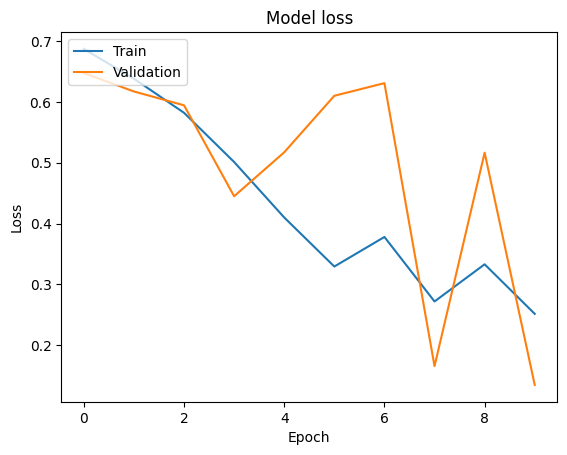

In [437]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step
                precision    recall  f1-score   support

Non-Solar Farm       0.56      0.54      0.55        28
    Solar Farm       0.55      0.57      0.56        28

      accuracy                           0.55        56
     macro avg       0.55      0.55      0.55        56
  weighted avg       0.55      0.55      0.55        56



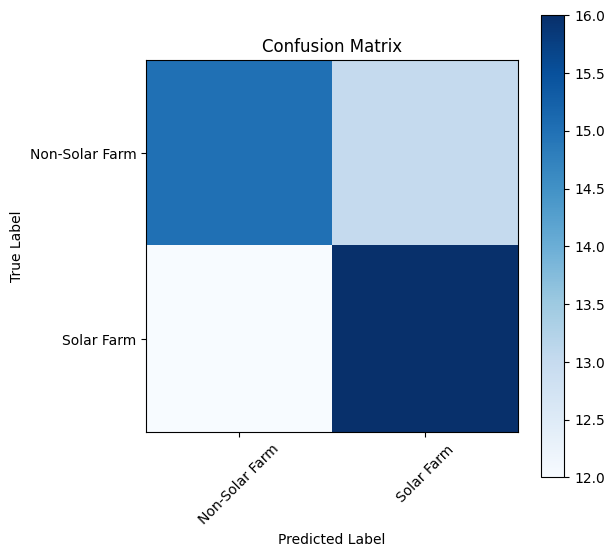

In [451]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Get predictions
y_pred = model.predict(validation_generator)
y_pred = np.round(y_pred)  # Convert probabilities to binary predictions

# Get true labels
y_true = validation_generator.classes

# Print classification report
print(classification_report(y_true, y_pred, target_names=['Non-Solar Farm', 'Solar Farm']))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Non-Solar Farm', 'Solar Farm'], rotation=45)
plt.yticks(tick_marks, ['Non-Solar Farm', 'Solar Farm'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
#This confusion matrix of then model I saved had better Precision and F1 score. The matrix represented below does not show the best model

In [399]:
model.save('solar_farm_model_best.h5')